<a href="https://colab.research.google.com/github/ldivrala/Face-Recognition-Training/blob/main/TorchFace_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
import torchvision.models as models
from torch.utils.data import DataLoader



Load dataset from google drive

In [2]:
# Connect with Google Drive for dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Zips/trainset.zip -d /content/sample_data

Archive:  /content/drive/MyDrive/Zips/trainset.zip
replace /content/sample_data/trainset/0001/0001_0000255/0000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### We will use vgg16 pretrained model for feature extraction
We will train this model for 108 feature extraction a face.

In [6]:
data_transform = transforms.Compose([
        transforms.Resize((256, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ])

In [7]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
for layer in vgg16.features:
    layer.training = False


vgg16.face_recognition = nn.Sequential(
    nn.Linear(in_features=1000, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=108, bias=True)
)

vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Dataset creation Process

In [18]:
import random
dataset2 = []
trainset_dirs = "/content/sample_data/trainset/"

for trainset_dir in os.listdir(trainset_dirs):
    image_dirs = os.listdir(trainset_dirs + trainset_dir)
    
    for i in range(len(image_dirs)):
        
        image_dir = image_dirs[i]
        
        # Face Images
        user_images = os.listdir(trainset_dirs+ trainset_dir + "/" + image_dir)
        
        user_other_images = []
        for image in user_images:
          if "script" in image:
            user_passport_image = trainset_dirs + trainset_dir + "/" + image_dir + "/" + image
          else:
            user_other_images.append(trainset_dirs + trainset_dir + "/" + image_dir + "/" + image)

        
        random_numbers = [random.randint(0, len(image_dirs)-1) for _ in range(4)]
        
        random_image_dirs = [image_dirs[j] for j in random_numbers if i != j]
    
        for other_image_dir in random_image_dirs:
            other_images = os.listdir(trainset_dirs+ trainset_dir + "/" + other_image_dir)

            for user_image in user_other_images:
              for other_image in other_images:

                diffrent_user_image = trainset_dirs+ trainset_dir + "/" + other_image_dir + "/" + other_image

                # (Diffrent Face, Same Face, Same Face)
                dataset2.append([user_passport_image, user_image, diffrent_user_image])



In [19]:
dataset2 = np.array(dataset2)

### Create dataset pipeline with pytorch

In [20]:
class CustomImageDataset2(Dataset):
    def __init__(self, img_dirs, transform=None, target_transform=None):
        self.images1 = img_dirs[:, 0]
        self.images2 = img_dirs[:, 1]
        self.images3 = img_dirs[:, 2]
        
        self.transform = transform
        
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img_path1 = os.path.join(self.images1[idx])
        img_path2 = os.path.join(self.images2[idx])
        img_path3 = os.path.join(self.images3[idx])
        
        image1 = PIL.Image.open(img_path1).convert('RGB')
        image2 = PIL.Image.open(img_path2).convert('RGB')
        image3 = PIL.Image.open(img_path3).convert('RGB')
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
        
        return image1, image2, image3

In [21]:
def display(display_list):

    title = ["Passport Image", "Same User Image", "Diffrent User Image"]
    plt.figure(figsize=(15, 15))


    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)

        plt.title(title[i])

        plt.imshow(display_list[i].permute(1, 2, 0) * 0.229 + 0.485)
        plt.axis("off")
    
    plt.show()

In [22]:
torch.cuda.empty_cache()

First Image = Passport Size Image \
Second Image = same User Image  \
Third Image = Diffrent User Image

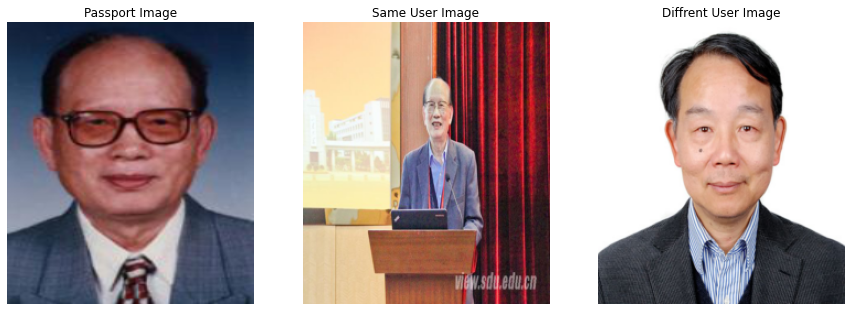

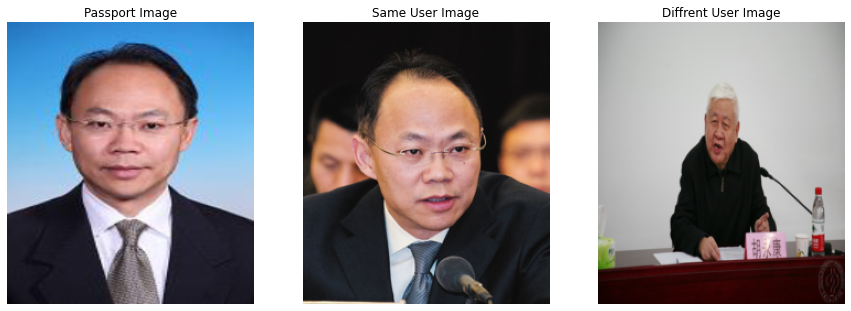

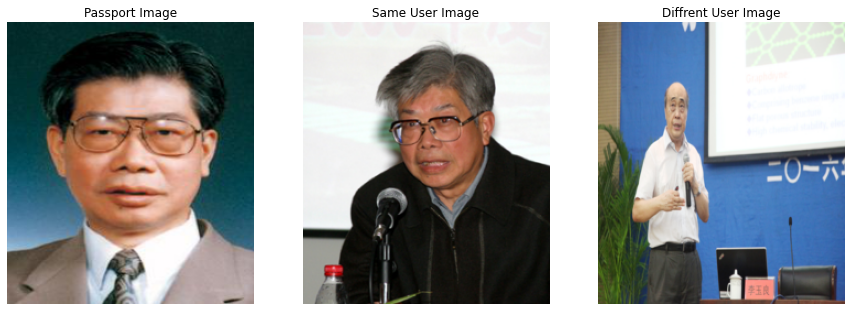

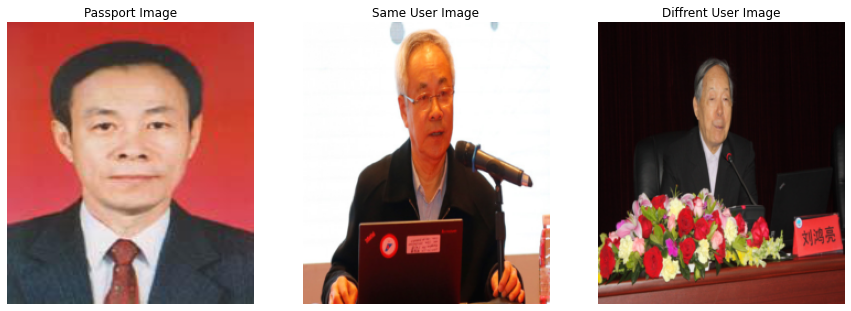

In [23]:
train_dataloader2 = DataLoader(CustomImageDataset2(dataset2, data_transform), batch_size= 64, shuffle=True)

for i, images in enumerate(train_dataloader2):
  image1, image2, image3 = images

  for j in range(2):
    display([image1[j], image2[j], image3[j]])

  if i == 1:
    break

### Model

In [24]:
# Model definition
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.vgg = vgg16

    def forward(self, input1, input2, input3):
        x1 = self.vgg(input1)
        x2 = self.vgg(input2)
        x3 = self.vgg(input3)

        return x1, x2, x3

In [25]:
model = ModelNet().half().cuda()

### We will use triplet loss function

In [26]:
# @torch.jit.script
def criterion(output1, output2, output3):
    same_image_loss = torch.mean((output1 - output2) ** 2, 1)
    diffrent_image_loss = torch.mean((output1 - output3) ** 2, 1)
    
    loss = same_image_loss - diffrent_image_loss + 0.3

    loss = torch.mean(torch.maximum(loss, torch.zeros_like(loss)))
    return loss
    
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


### Training Process

In [28]:
def train(epochs):
    model.train()

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataloader2, 0):
            # get the inputs; data is a list of [inputs, labels]
            input1, input2, input3 = data

            input1 = input1.half().cuda() 
            input2 = input2.half().cuda()  
            input3 = input3.half().cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(input1, input2, input3)
            
            loss = criterion(outputs[0], outputs[1], outputs[2])

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i < 20 and i % 2 == 0:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 5))
                running_loss = 0.0

            
            if i % 50 == 49:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0

    print('Finished Training')
    

In [ ]:
train(5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,     1] loss: 0.295
[1,     3] loss: 0.416
[1,     5] loss: 0.242
[1,     7] loss: 0.188
[1,     9] loss: 0.127
[1,    11] loss: 0.125
[1,    13] loss: 0.126
[1,    15] loss: 0.115
[1,    17] loss: 0.121
[1,    19] loss: 0.113


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


[1,    50] loss: 0.182
[1,   100] loss: 0.273
[1,   150] loss: 0.243
[1,   200] loss: 0.213
[1,   250] loss: 0.196
[1,   300] loss: 0.172
[1,   350] loss: 0.150
[1,   400] loss: 0.141
[1,   450] loss: 0.138
[1,   500] loss: 0.131
[1,   550] loss: 0.125
[1,   600] loss: 0.110
[1,   650] loss: 0.110
[1,   700] loss: 0.096
[1,   750] loss: 0.096
[1,   800] loss: 0.093
[1,   850] loss: 0.096
[2,     1] loss: 0.013
[2,     3] loss: 0.033
[2,     5] loss: 0.041
[2,     7] loss: 0.026
[2,     9] loss: 0.038
[2,    11] loss: 0.028
[2,    13] loss: 0.048
[2,    15] loss: 0.034
[2,    17] loss: 0.041
[2,    19] loss: 0.039
[2,    50] loss: 0.048
[2,   100] loss: 0.076
[2,   150] loss: 0.076
[2,   200] loss: 0.075
[2,   250] loss: 0.067
[2,   300] loss: 0.068
[2,   350] loss: 0.065
[2,   400] loss: 0.059
[2,   450] loss: 0.069
[2,   500] loss: 0.058
[2,   550] loss: 0.053
[2,   600] loss: 0.059
[2,   650] loss: 0.055
[2,   700] loss: 0.052
[2,   750] loss: 0.046
[2,   800] loss: 0.048
[2,   850] 

#### We must train this model for more than 200 epochs with low learning rate than we can get a good result

In [ ]:
torch.save(model, "/content/drive/MyDrive/Models/PyFaceRecognition")